### Workspace

In [223]:
%matplotlib notebook

from modsim import *
#from pdb import set_trace

In [224]:
altitude = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 
            8000, 9000, 10000, 15000, 20000, 25000, 30000,
           40000, 50000, 60000, 70000, 80000]
density = [1.225, 1.112, 1.007, .9093, .8194, .7364, .6601,
          .5900, .5258, .4671, .4135, .1948, .08891, .04008,
          .01841, .003996, .001027, .0003097, .00008283, .000001846]

thrust = [90, 204, 306, 388, 457, 523, 591, 664, 722, 774, 836, 887,
          942, 995, 1045, 1098, 1150, 1208, 1236]

newton_thrust = np.asarray(thrust) * 9.81 * 4 /1000
#print(newton_thrust)
#max thrust = 1.07 * 9.81 kg
current = [1, 3.1, 5.1, 7.1, 9.1, 11.1, 13.1, 15.2, 17.1, 19.1, 21.2,
           23.2, 25.2, 27.3, 29.3, 31.3, 33.3, 35.1, 36.4]

    
dd_da = TimeSeries()
for i in range(20):
    x = altitude[i]
    y = density[i]
    dd_da[x] = y
dd_da = interpolate(dd_da, kind='cubic')

ft_amp = TimeSeries()
count = 0
for i in range(19):
    x = newton_thrust[i] 
    y = current[i] * 4
    ft_amp[x] = y
ft_amp = interpolate(ft_amp, kind='cubic')

In [225]:
condition = Condition(height=90000,
                      thrust_on=200,
                      land = 10,
                      f_thrust=20,
                      mass= .575,
                      length=.1,
                      width=.1,
                      dd_da=dd_da,
                      C_d=.3,
                      g=9.8,
                      dt=1)

In [234]:
def make_system(condition):
    unpack(condition)
    
    init = State(height=height, velocity=0, acceleration=0, thrust=0, drag=0)
    
    drag_coef = -.3 * .017279
    #drap_coef = C_d * length*width
    system = System(init=init,
                    dt=dt,
                    thrust_on=thrust_on, land=land,
                    f_thrust=f_thrust,
                    mass=mass,
                    drag_coef=drag_coef,
                    charge=0,
                    dd_da=dd_da)
    return system

def slope(state, system, dt, count):
    unpack(system)
    height, velocity, acceleration, thrust, drag = state
    
    f_drag = drag_coef * abs(velocity) * velocity * abs(dd_da(height))
    #print(f_drag)
    a_drag = f_drag/mass
    
    if (height < thrust_on):
        f_t= find_thrust_2(height, velocity, g, a_drag, land) * mass
        #print(f_t)
    else:
        f_t=0
    
    system.charge = find_charge(charge, mass, f_t, dt)

    a_thrust = f_t/mass
    a_grav = -g
    a = a_grav + a_thrust + a_drag
    dV = a*dt
    velocity += dV
    
    dH = velocity*dt
    height += dH
    
    return State(height=height, velocity=velocity, acceleration=a, thrust=f_t, drag=f_drag)


def find_thrust(height, velocity, g, a_drag, land):
    if height < land:
        a_thrust = g + (velocity)**2/(2*height)
    else:
        a_thrust = (g-a_drag) + (abs(velocity)-10)**2/(2*height)
    return a_thrust

def find_thrust_2(height, velocity, g, a_drag, land):
    a_thrust = (g-abs(a_drag)) + (abs(velocity)**2)/(2*height)
    
    if a_thrust < 0:
        a_thrust = 0
    return a_thrust

def find_charge(charge, mass, thrust, dt):
    current = ft_amp(thrust)
    if thrust <= 0:
        current = 0;
    time = dt / 3600
    current_time = current * time * 4
    
    charge += current_time
    #print(charge)
    return charge
    

def run_ode_best(system, slope_func):
    count = 0
    iteration = 0
    unpack(system)
    frame = TimeFrame(columns=init.index)
    acceleration = TimeSeries()
    
    frame.loc[0] = init
    while(frame.loc[count].velocity < -1 or count < 5):
        frame.loc[count+dt] = slope_func(frame.loc[count], system, dt, count)
        count += dt
        
        iteration += 1
        if iteration >= 50000:
            system.results = frame
            system.count = count
            return
        #print(frame.loc[count])
    system.count = count
    system.results = frame
    
def plot_height(system):
    newfig()
    plot(system.results.height, label='y')
        
    decorate(xlabel='Time (s)',
             ylabel='Position (m)',
             title='Height of Quadcopter')
    plt.tight_layout()
    savefig('height_graph.pdf')
    
def plot_velocity(system):
    newfig()
    plot(system.results.velocity, label='v')
    
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)',
             title='Velocity of Quadcopter')
    plt.tight_layout()
    savefig('velocity_graph.pdf')
    
def plot_acceleration(system):
    newfig()
    plot(system.results.acceleration, label='a')
    
    decorate(xlabel='Time (s)',
             ylabel='Acceleration (m/s^2)',
             title='Net Acceleration of Quadcopter')
    plt.tight_layout()
    savefig('acceleration_graph.pdf')
def plot_atmosphere():
    newfig()
    for i in linrange(1,100000, 5000):
        plot(i, dd_da(i), 'g-')
    decorate(xlabel='Altitude(m)',
             ylabel='Air density (kg/m^3)',
             title='Air Density vs. Altitude')
    plt.tight_layout()
    savefig('atmosphere_graph.pdf')
def plot_current():
    newfig()
    for i in linrange(1,50, 1):
        plot(i, ft_amp(i), 'g-')
    decorate(xlabel='Thrust(N)',
             ylabel='Current (Amp)',
             title='Thrust vs. Current')
    #plt.tight_layout()
    savefig('current_graph.pdf')
def sweep_height(minm, maxm, dt):
    sweep = SweepSeries()
    for i in linrange(minm, maxm, dt):
        print(i)
        condition.set(thrust_on=i)
        system = run_simulation()
        sweep[i] = system.charge
    newfig()
    plot(sweep, label='charge consumed')
    decorate(xlabel='Height where Motor Starts (m)',
             ylabel='Charge Consumed (Ah)')
    plt.tight_layout()
    savefig('landing_height_graph.pdf')
    
    
def height_at_zero(system):
    t_end = system.count
    #print(t_end)
    t_start = system.count - system.dt
    #print(t_start)
    height = (system.results.height[t_start] + system.results.height[t_end])/2
    return height
def calc_avg_thrust(system):
    thrust_height = system.thrust_on

    a = interp_inverse(system.results.height)
    t_start = int(a(thrust_height))
    t_end = system.count

    thrust = system.results.thrust[t_start:]
    #a = interpolate(system.results.thrust)
    #a_sum = 0
    #for i in linrange(t_start, t_end, ):
    #    a_sum += a(i)
    #a_avg = a_sum/(t_end-t_start)
    # 
    # system.thrust = a_avg
    system.thrust = thrust[thrust.idxmax()]
def run_simulation():
    system = make_system(condition)
    run_ode_best(system, slope)
    system.final_height = height_at_zero(system)
    calc_avg_thrust(system)
    return system

In [227]:
condition.set(dt= .1)
condition.set(height = 80000)
condition.set(thrust_on = 24)
run_space_high = run_simulation()

In [201]:
run_space_high.thrust

16.147235177407079

In [121]:
condition.set(dt= .1)
condition.set(height = 80000)
condition.set(thrust_on = 2000)
run_space_low = run_simulation()

<IPython.core.display.Javascript object>


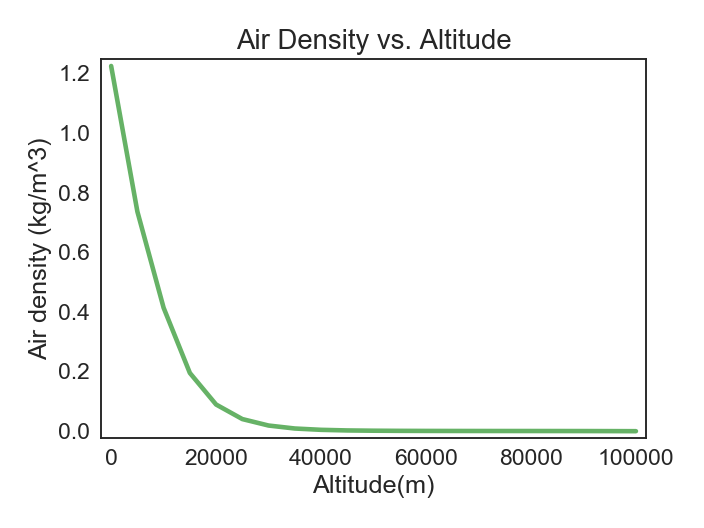

Saving figure to file atmosphere_graph.png


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [228]:
plot_atmosphere()

<IPython.core.display.Javascript object>


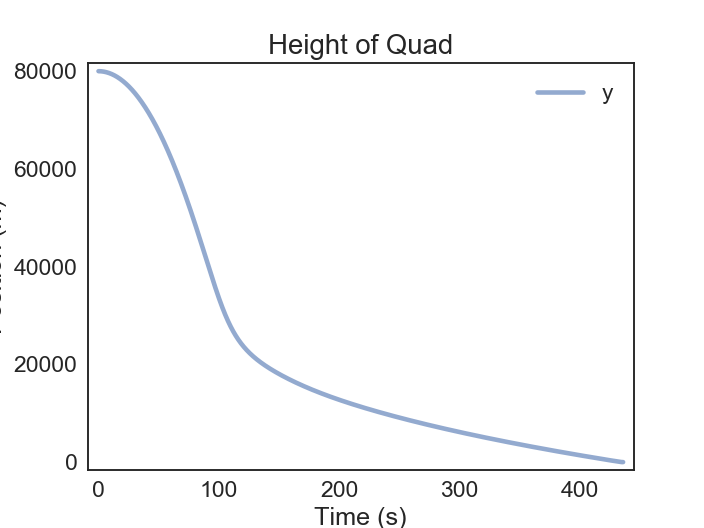

<IPython.core.display.Javascript object>


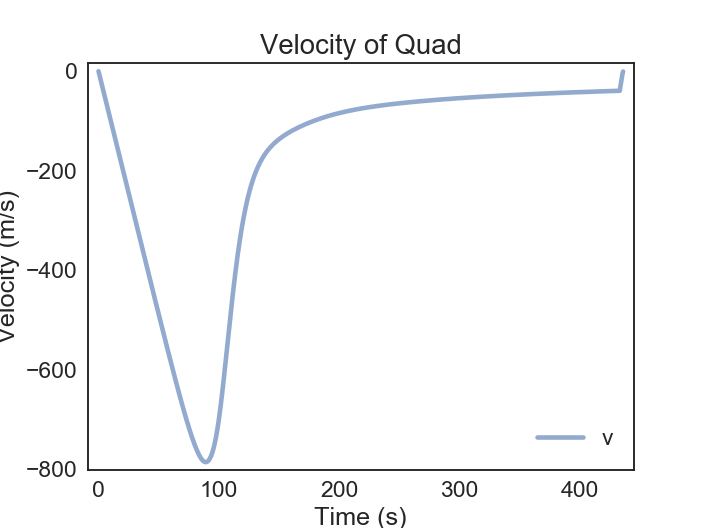

<IPython.core.display.Javascript object>


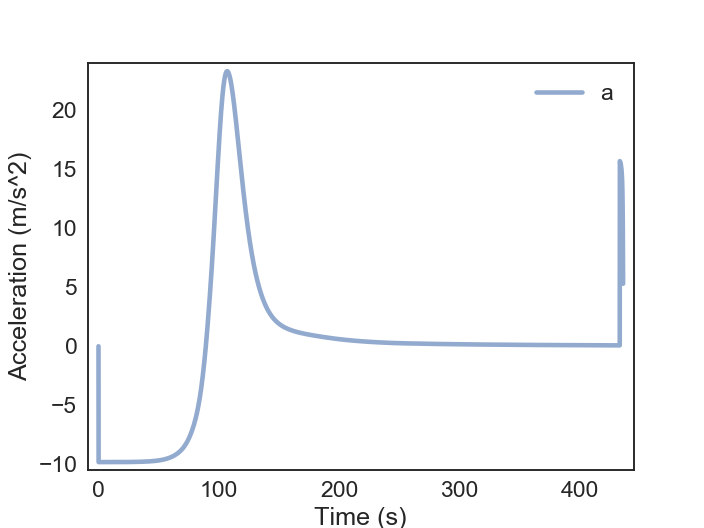

In [167]:
plot_height(run_space_high)
plot_velocity(run_space_high)
plot_acceleration(run_space_high)

<IPython.core.display.Javascript object>


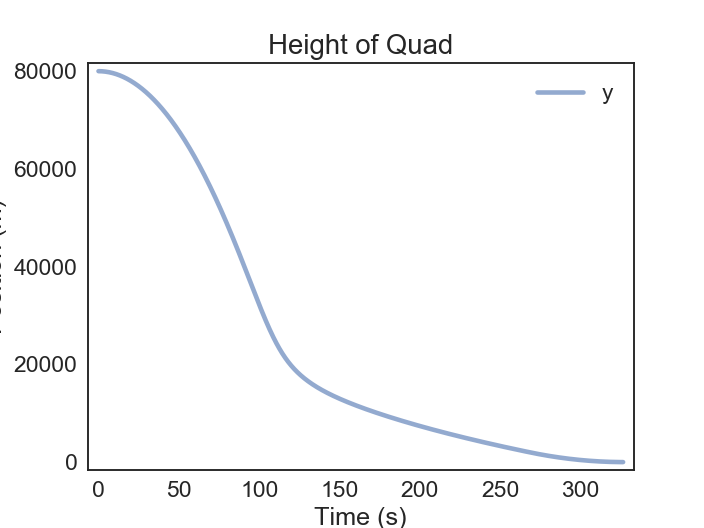

<IPython.core.display.Javascript object>


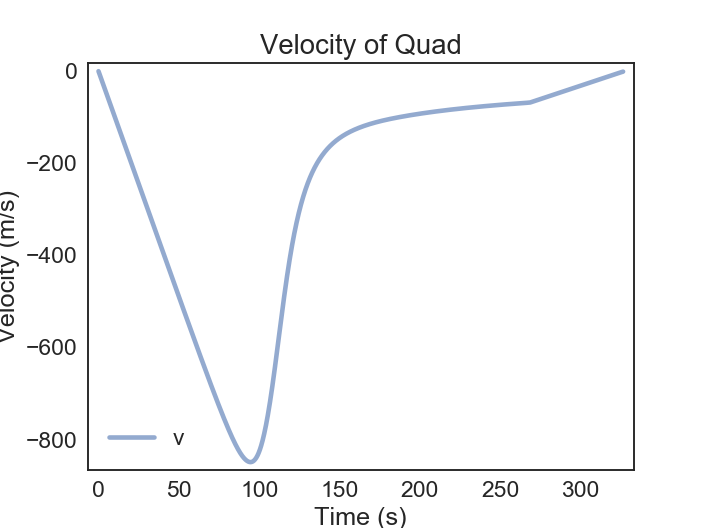

<IPython.core.display.Javascript object>


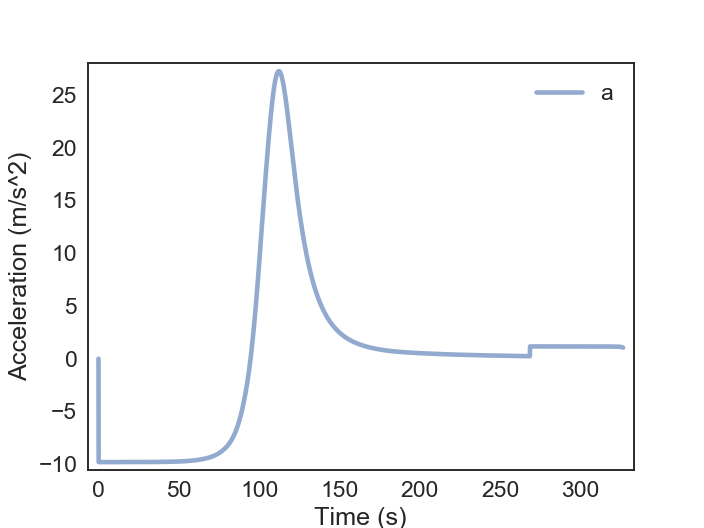

In [52]:
plot_height(run_space_low)
plot_velocity(run_space_low)
plot_acceleration(run_space_low)

20.0
40.0
60.0
80.0
100.0
120.0
140.0
160.0
180.0
200.0
220.0
240.0
260.0
280.0
300.0


<IPython.core.display.Javascript object>


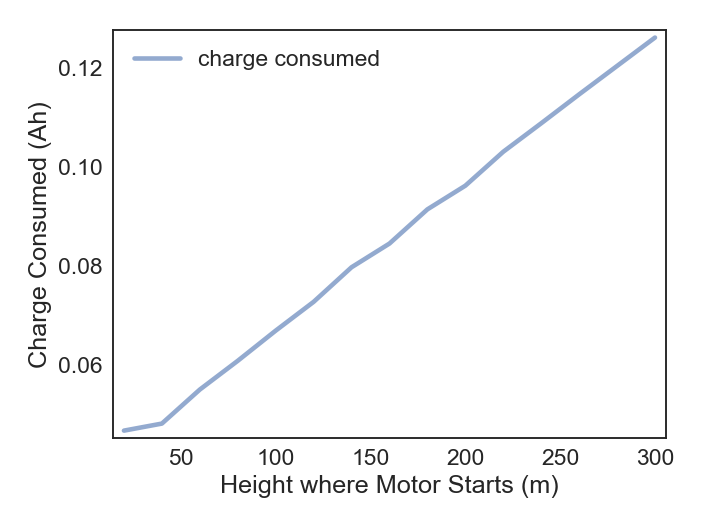

Saving figure to file landing_height_graph.png


In [220]:
sweep_height(minm=20, maxm=300, dt=20)

<IPython.core.display.Javascript object>


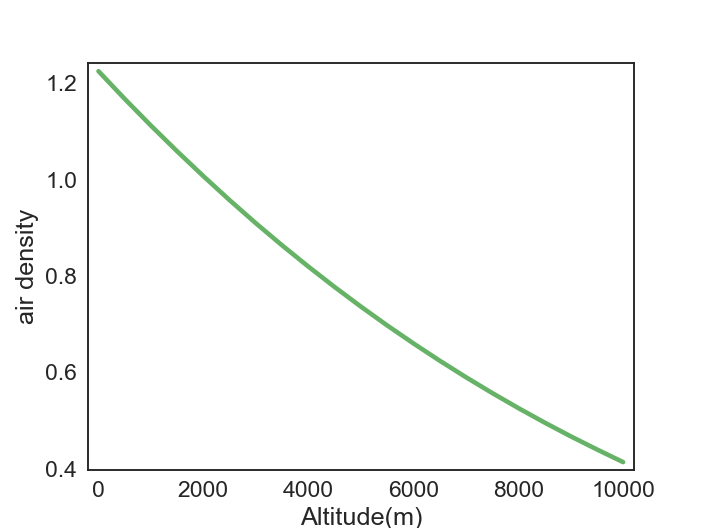

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [42]:
plot_atmosphere()

<IPython.core.display.Javascript object>


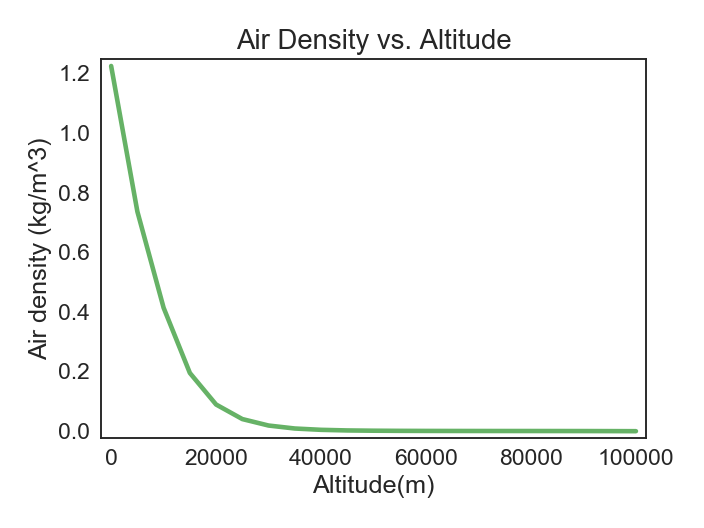

Saving figure to file atmosphere_graph.pdf


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


<IPython.core.display.Javascript object>


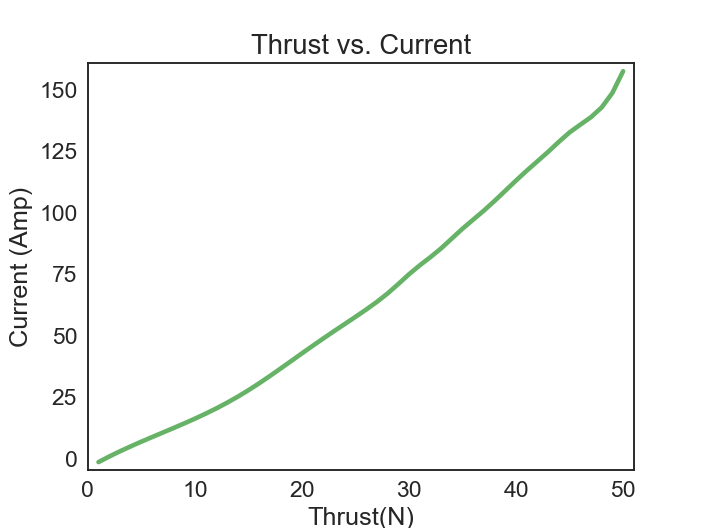

Saving figure to file current_graph.pdf


<IPython.core.display.Javascript object>


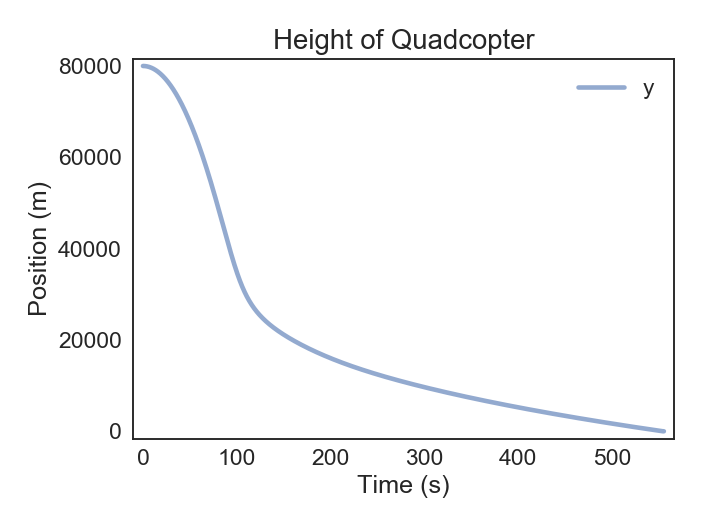

Saving figure to file height_graph.pdf


<IPython.core.display.Javascript object>


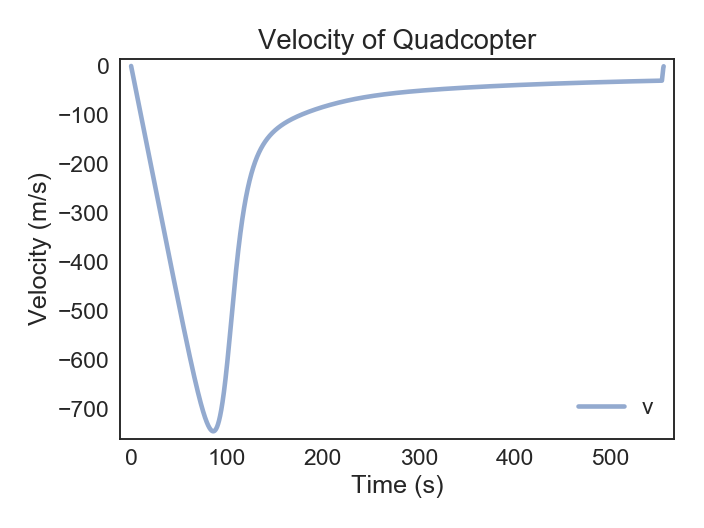

Saving figure to file velocity_graph.pdf


<IPython.core.display.Javascript object>


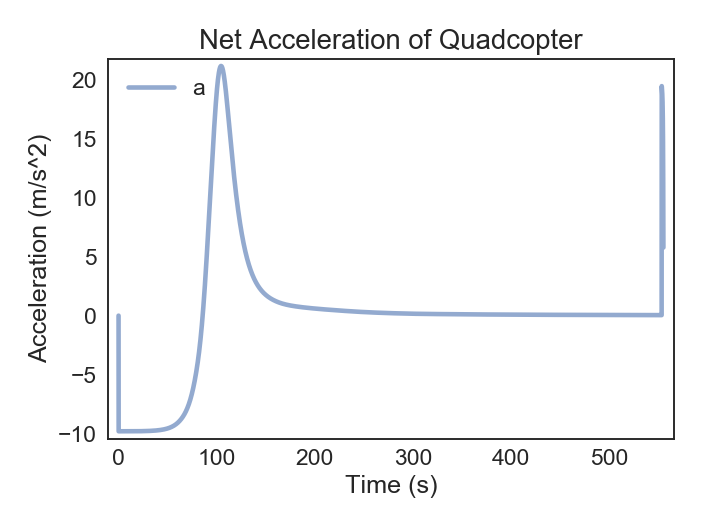

Saving figure to file acceleration_graph.pdf


In [235]:
plot_atmosphere()
plot_current()
plot_height(run_space_high)
plot_velocity(run_space_high)
plot_acceleration(run_space_high)
#sweep_height(minm=10, maxm=200, dt=10)